In [147]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from neuraldb.dataset.base_reader import NeuralDatabaseDatasetReader
from neuraldb.dataset.generators.v0_4_database_reader import V4DatabaseSpecificReader
from matplotlib import pyplot as plt

In [148]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=fusion_sweep"
checkpoint_name = "metrics_test.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

556


In [138]:
def expand(idx,chunk):

  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data["context"] = int(data["context"])
    data['dir'] = os.path.dirname(file)
    data["filter_size"] = int(data["filter_size"])
    data["lr"] = float(data["lr"])
    if data["version"] == "v0.4":
        experiments.append(data)

In [139]:
for experiment in experiments:
    with open(experiment['file']) as f:
        results = json.load(f)

    experiment["EM"] = results['test']["EM"]

    for k,v in results['test']["raw"]["relation_type"].items():
        experiment["breakdown_{}".format(k)] = np.mean(v)

    for k,v in results['test']["raw"]["query_type"].items():
        experiment["query_{}".format(k)] = np.mean(v)



In [146]:
results = pd.DataFrame(experiments).fillna(0)
results = results[results["version"]=="v0.4"]
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("breakdown_") or col.startswith("query_"),results.columns)}

query_cols = list(filter(lambda col: col.startswith("query_"),results.columns))
print(query_cols)
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
breakdown = pd.pivot_table(results, index=["model","context","version","filter_size"],columns=[], aggfunc=cols)
breakdown



['query_atomic', 'query_join', 'query_list', 'query_agg', 'query_min_max']


EM           breakdown_born_in  \
                                         mean       std              mean   
model   context version filter_size                                         
t5-base 50      v0.4    1            0.802845  0.001149          0.745366   
                        2            0.775546  0.002309          0.729934   
                        4            0.770178  0.001080          0.737484   
                        6            0.768351  0.001626          0.743643   
                        8            0.768670  0.002310          0.742911   
...                                       ...       ...               ...   
        10000   v0.4    8            0.776580  0.004266          0.752109   
                        12           0.776833  0.002468          0.748978   
                        16           0.777746  0.003616          0.748455   
                        24           0.777602  0.002438          0.748207   
                        32           0.773920  0.005129          0.742018   

                                              breakdown_continent_location  \
                                          std                         mean   
model   context version filter_size                                          
t5-base 50      v0.4    1            0.001696                     0.857143   
                        2            0.005634                     0.856122   
                        4            0.013422                     0.852041   
                        6            0.006143                     0.854082   
                        8            0.006047                     0.858163   
...                                       ...                          ...   
        10000   v0.4    8            0.012088                     0.250000   
                        12           0.013299                     0.266667   
                        16           0.011551                     0.308333   
                        24           0.007644                     0.325000   
                        32           0.011549                     0.250000   

                                              breakdown_country_location  \
                                          std                       mean   
model   context version filter_size                                        
t5-base 50      v0.4    1            0.003608                   0.377377   
                        2            0.008384                   0.340707   
                        4            0.000000                   0.369924   
                        6            0.004563                   0.360678   
                        8            0.004269                   0.366778   
...                                       ...                        ...   
        10000   v0.4    8            0.000000                   0.000000   
                        12           0.037268                   0.000000   
                        16           0.055902                   0.000000   
                        24           0.068465                   0.000000   
                        32           0.000000                   0.000000   

                                              breakdown_educated_at            \
                                          std                  mean       std   
model   context version filter_size                                             
t5-base 50      v0.4    1            0.008216              0.848697  0.003094   
                        2            0.043422              0.812294  0.008105   
                        4            0.048334              0.797483  0.002060   
                        6            0.048231              0.793426  0.011209   
                        8            0.022341              0.795728  0.012642   
...                                       ...                   ...       ...   
        10000   v0.4    8            0.000000              0.755857  0.005345

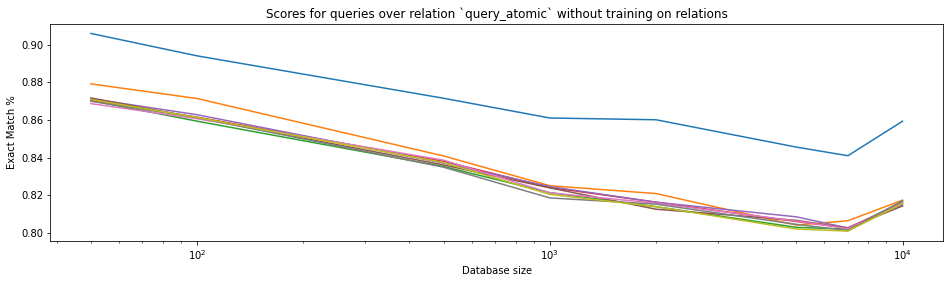

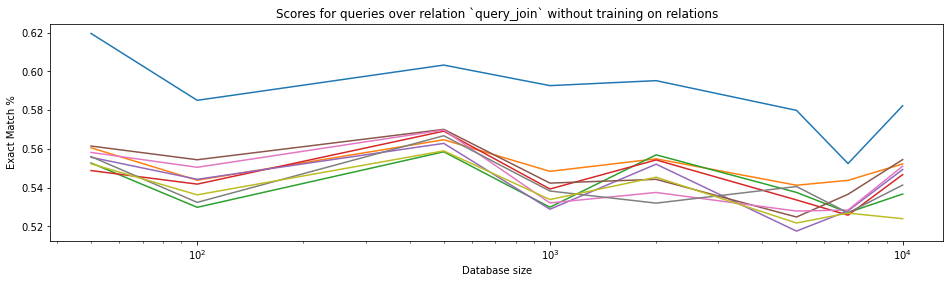

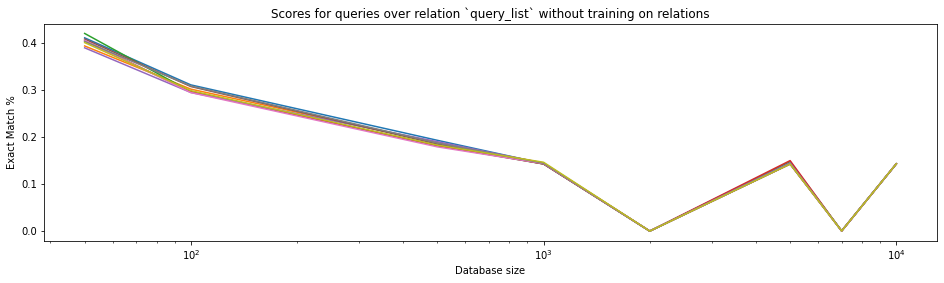

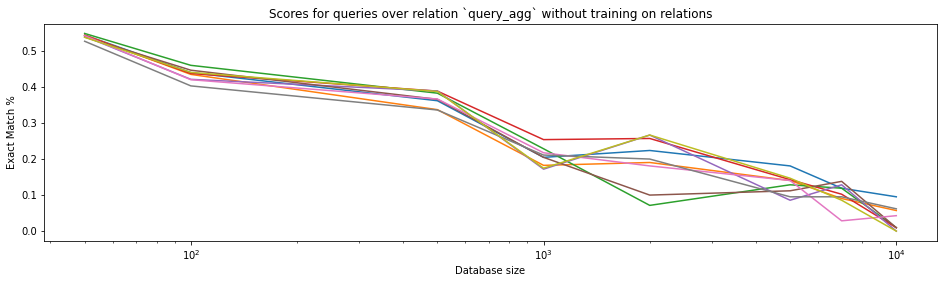

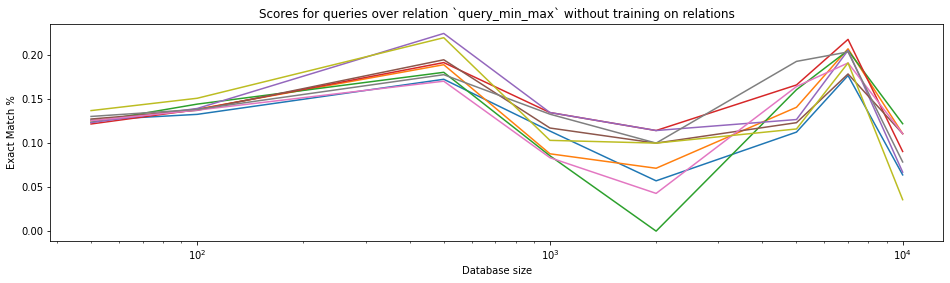

In [141]:
ds_sizes = [50,100,500,1000,2000,5000,7000,10000]
for col in query_cols:
    means = [breakdown[col]["mean"].T["t5-base"][ds]["v0.4"] for ds in ds_sizes]
    std = [breakdown[col]["std"].T["t5-base"][ds]["v0.4"] for ds in ds_sizes]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=0)
    plt.xscale("log")

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Database size")
    plt.ylabel("Exact Match %")
    plt.plot(ds_sizes, means)
    #plt.fill_between(range(len(std)), [m-s for m,s in zip(means, std)],[m+s for m,s in zip(means, std)],alpha=0.1)
    plt.show()

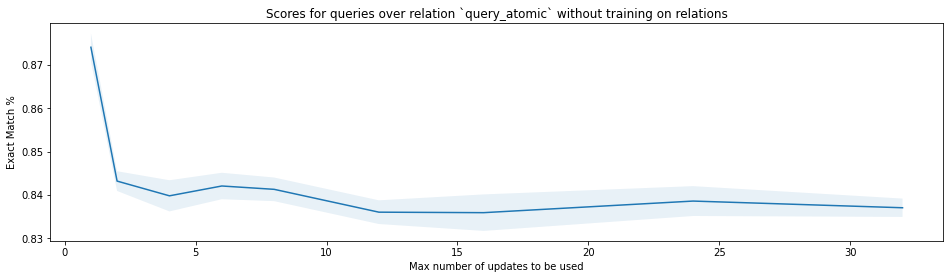

In [105]:
ds = 500
col = "query_atomic"
means = breakdown[col]["mean"].T["t5-base"][ds]["v0.5"]
std = breakdown[col]["std"].T["t5-base"][ds]["v0.5"]
plt.figure(figsize=(16,4))
plt.xticks(rotation=0)


plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
plt.xlabel("Max number of updates to be used")
plt.ylabel("Exact Match %")
plt.plot(means)
plt.fill_between(means.index, [m-s for m,s in zip(means, std)],[m+s for m,s in zip(means, std)],alpha=0.1)
plt.show()



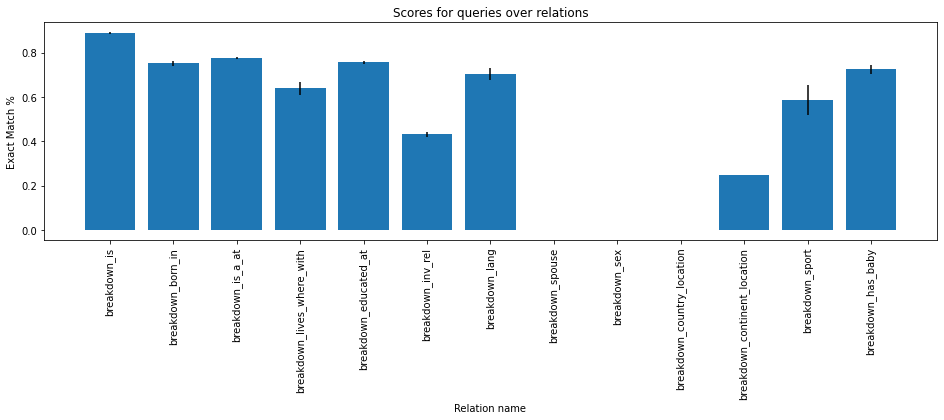

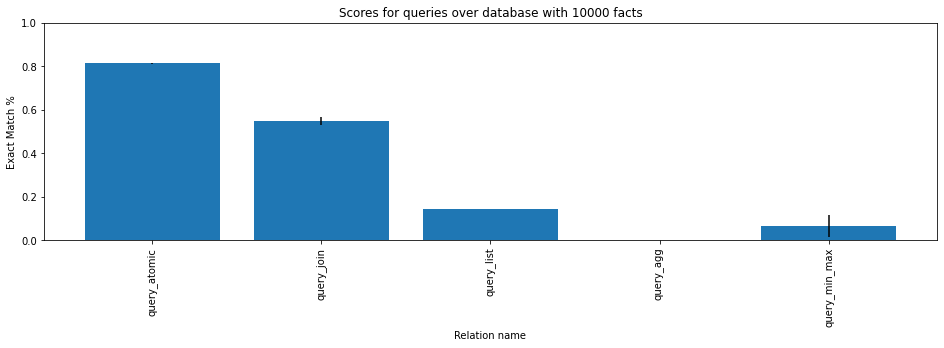

In [145]:
means = []
std = []
rs =10000
for col in breakdown_cols:
    means.append(breakdown[col]["mean"].T["t5-base"][rs]["v0.4"][8])
    std.append(breakdown[col]["std"].T["t5-base"][rs]["v0.4"][8])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("Scores for queries over relations")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(breakdown_cols, means, yerr=std)
plt.show()


means = []
std = []

for col in query_cols:
    means.append(breakdown[col]["mean"].T["t5-base"][rs]["v0.4"][8])
    std.append(breakdown[col]["std"].T["t5-base"][rs]["v0.4"][8])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.ylim(0,1)

plt.title("Scores for queries over database with {} facts".format(rs))
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(query_cols, means, yerr=std)
plt.show()